### Loading the required libraries

In [1]:
import os
import sys
import cv2
import math
import torch
import numpy as np
import logging as log
import matplotlib.pyplot as plt
from openvino.inference_engine import IENetwork, IECore

### Class for working with the Inference Engine

In [2]:
class Network:
    '''
    Load and store information for working with the Inference Engine,
    and any loaded models.
    '''

    def __init__(self):
        self.plugin = None
        self.network = None
        self.input_blob = None
        self.output_blob = None
        self.exec_network = None
        self.infer_request = None

    def load_model(self, model, device="CPU", cpu_extension=None):
        '''
        Load the model given IR files.
        Defaults to CPU as device for use in the workspace.
        Synchronous requests made within.
        '''
        model_xml = model
        model_bin = os.path.splitext(model_xml)[0] + ".bin"

        # Initialize the plugin
        self.plugin = IECore()

        # Add a CPU extension, if applicable
        if cpu_extension and "CPU" in device:
            self.plugin.add_extension(cpu_extension, device)

        # Read the IR as a IENetwork
        self.network = IENetwork(model=model_xml, weights=model_bin)

        # Load the IENetwork into the plugin
        self.exec_network = self.plugin.load_network(self.network, device)

        # Get the input layer
        self.input_blob = next(iter(self.network.inputs))
        self.output_blob = next(iter(self.network.outputs))

        return

    def get_input_shape(self):
        '''
        Gets the input shape of the network
        '''
        return self.network.inputs[self.input_blob].shape

    def async_inference(self, image):
        '''
        Makes an asynchronous inference request, given an input image.
        '''
        self.exec_network.start_async(
            request_id=0, inputs={self.input_blob: image})
        return

    def wait(self):
        '''
        Checks the status of the inference request.
        '''
        status = self.exec_network.requests[0].wait(-1)
        return status

    def extract_output(self):
        '''
        Returns a list of the results for the output layer of the network.
        '''
        return self.exec_network.requests[0].outputs[self.output_blob]

### Initialize the Inference Engine

In [3]:
plugin = Network()

### Load the network model into the IE

In [4]:
plugin.load_model("ppn_onnx_model.xml", "CPU")

RuntimeError: Error reading network: cannot parse future versions: 10

### Check the input shape

In [5]:
net_input_shape = plugin.get_input_shape()
print(net_input_shape)

[1, 10]


### Creating input

In [7]:
img_size = 500
scale = 0.3
z_size = 7
num_images = 2

In [6]:
def createInputVec(z, x, y):
    r = math.sqrt(((x * scale - (img_size * scale / 2))**2) + (
        (y * scale - (img_size * scale / 2))**2))
    z_size = len(z)
    input = torch.rand(1, z_size + 3)

    for i in range(z_size):
        input[0][i] = z[i] * scale

    input[0][z_size] = x * scale
    input[0][z_size + 1] = y * scale
    input[0][z_size + 2] = r
    return input

### Process output after inference

In [8]:
def run_and_plot():
    z = torch.rand(z_size)

    for i in range(num_images):
        print(i)
        z[0] = z[0] + 1
        z[1] = z[1] + 1
        z[2] = z[2] + 1
        z[3] = z[3] + 1
        z[4] = z[4] + 1
        z[5] = z[5] + 1
        z[6] = z[6] + 1

        image = np.zeros((img_size**2, 3))
        for i in range(img_size):

            for j in range(img_size):
                input = createInputVec(z, i, j)

                # Perform inference on the input
                plugin.async_inference(input)

                # Get the output of inference
                if plugin.wait() == 0:
                    result = plugin.extract_output()

                    # Assign the output
                    image[i * img_size + j] = result

        image = image.reshape(img_size, img_size, 3)

        imgplot = plt.imshow(image)
        plt.show()

### Perform Inference / Generate patterns

0


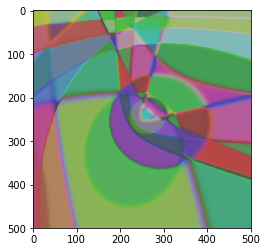

1


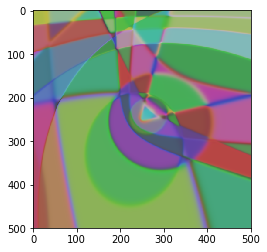

In [9]:
run_and_plot()

0


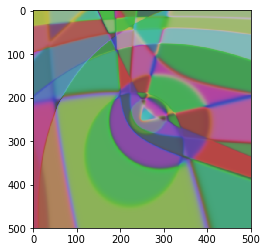

1


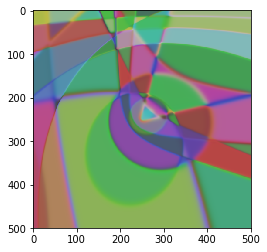

In [10]:
run_and_plot()

0


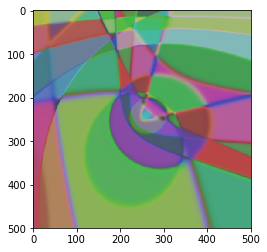

1


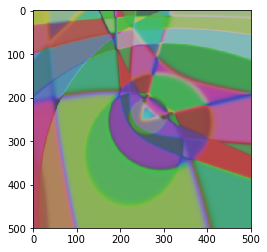

In [11]:
run_and_plot()